# Part 3: Predicting the selection of comments on NYT articles as editor's picks

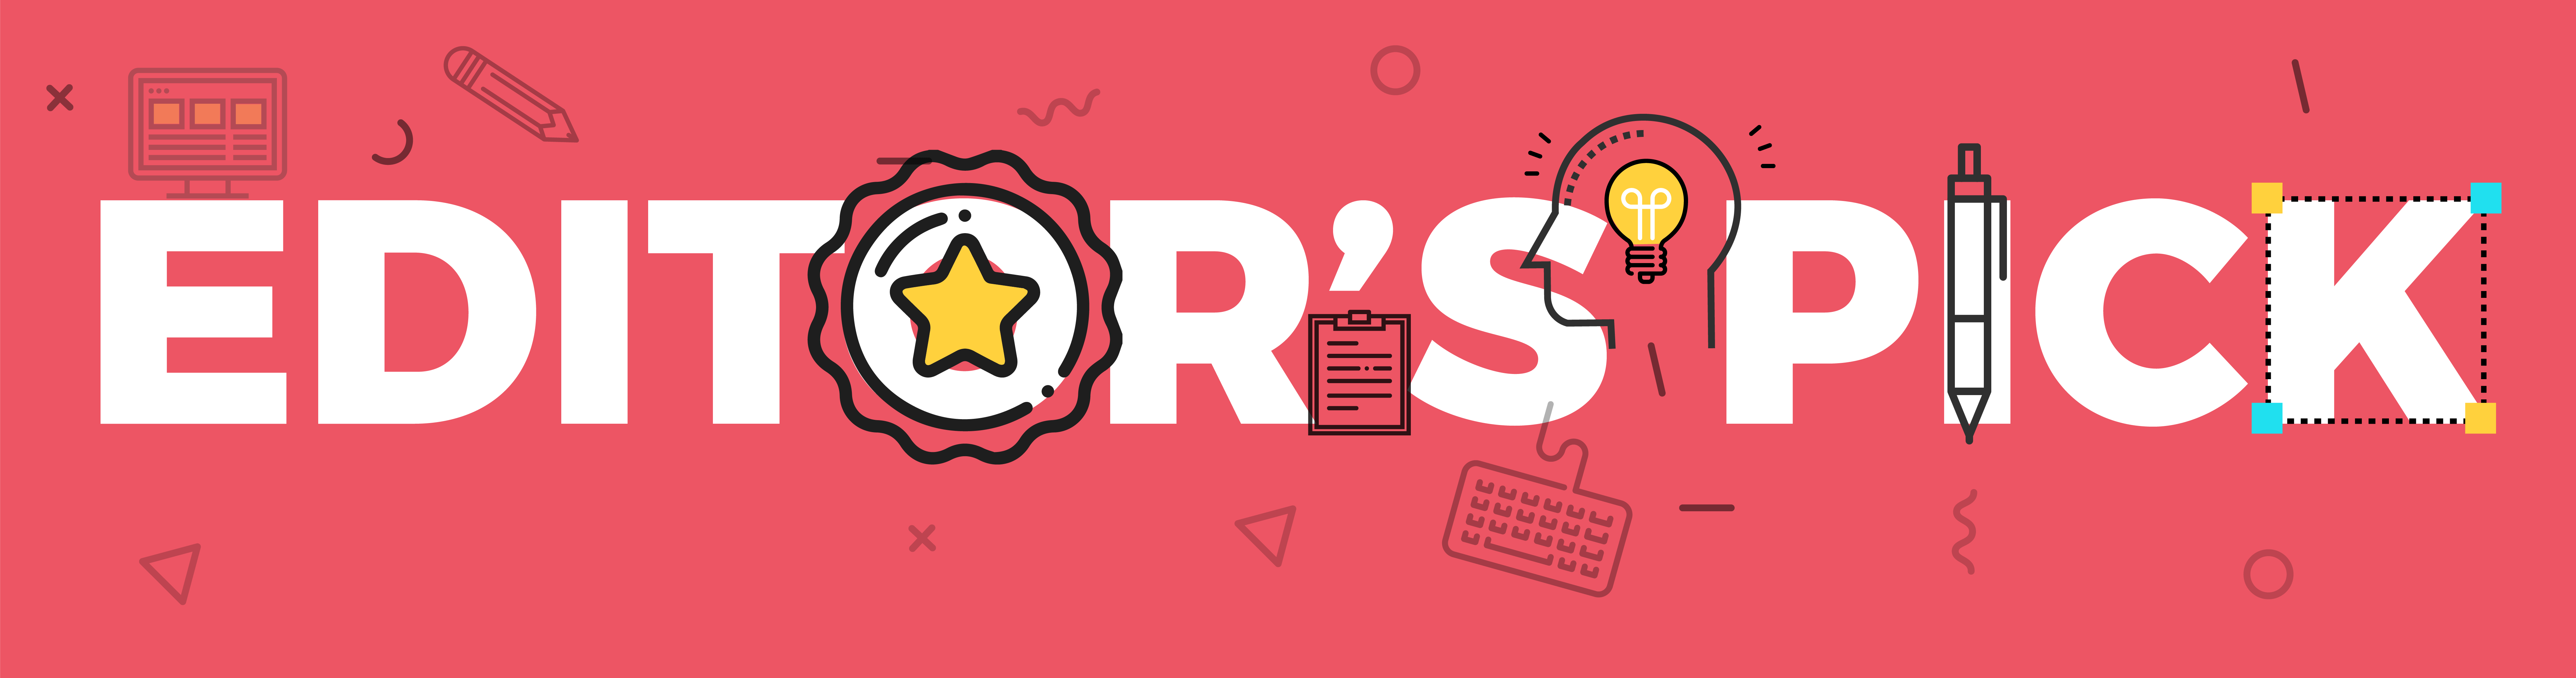

## Introduction

* For most articles on New York Times that are open to comments, there is a selection of comments' called NYT's pick.
* The dataset here contains the comments' text along with many features including the feature editorsSelection that indicates whether a comment was picked by NYT as editor's selection. 
* Two classifiers are trained to predict the probablities for the comments to be selected as NYT's picks.
* The first classifier uses Logistic Regression coupled with Latent Semantic Analysis (LSA) and the second classifier uses NB-Logistic Regression model

## Steps that we followed are as follows:

1. Importing modules and data
2. Balancing the classes to some extent by undersampling the majority class.
3. Obtaining and combining the tf-idf vectors for words and character n-grams using TDIDFVectorizer and FeatureUnion.
4. Training the first classifier that uses Logistic Regression coupled with Latent Semantic Analysis (LSA).
5. Training the second classifier that uses NB-Logistic Regression model 
6. Comparing the two classifiers by plotting the ROC and Precision-Recall curve.

**Importing modules and libraries**

In [2]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("data"))
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (roc_auc_score, classification_report, log_loss, make_scorer, 
                             recall_score, precision_recall_curve, roc_curve)

import gc
from time import time

['ArticlesApril2017.csv', 'ArticlesApril2018.csv', 'ArticlesFeb2017.csv', 'ArticlesFeb2018.csv', 'ArticlesJan2017.csv', 'ArticlesJan2018.csv', 'ArticlesMarch2017.csv', 'ArticlesMarch2018.csv', 'ArticlesMay2017.csv', 'ArticlesText.csv', 'CommentsApril2017.csv', 'CommentsApril2018.csv', 'CommentsFeb2017.csv', 'CommentsFeb2018.csv', 'CommentsJan2017.csv', 'CommentsJan2018.csv', 'CommentsMarch2017.csv', 'CommentsMarch2018.csv', 'CommentsMay2017.csv', 'masks-wordclouds']


**Importing data**

In [ ]:
c1 = pd.read_csv('data/CommentsJan2017.csv')
c2 = pd.read_csv('data/CommentsFeb2017.csv')
c3 = pd.read_csv('data/CommentsMarch2017.csv')
c4 = pd.read_csv('data/CommentsApril2017.csv')
c5 = pd.read_csv('data/CommentsMay2017.csv')
c6 = pd.read_csv('data/CommentsJan2018.csv')
c7 = pd.read_csv('data/CommentsFeb2018.csv')
c8 = pd.read_csv('data/CommentsMarch2018.csv')
c9 = pd.read_csv('data/CommentsApril2018.csv')
comments = pd.concat([c1, c2, c3, c4, c5, c6, c7, c8, c9])
comments.drop_duplicates(subset='commentID', inplace=True)

**The comments dataset contains many features, but for the starter model we will use only the text of the comments given by the column commentBody.**

* Before moving on to applying the models, we need to balance the classes. 
* So here the number of comments which are selected as NYT’s pick are very less compared to the number of comments that are actually present in NYT’s article, as you can see in the graph below

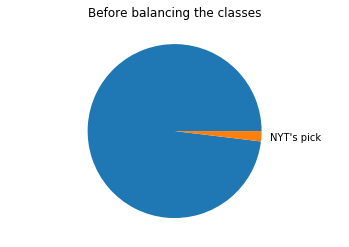

In [5]:
plt.axis('equal')
plt.pie(comments.editorsSelection.value_counts(), labels=("", "NYT's pick"));
plt.title("Before balancing the classes");

## 3.1 Balancing the classes by undersampling the majority class

**The two classes are highly imbalanced with an approxatimate ratio of 20:1. We will bring it down to less than 3:1 by undersampling the majority class**

* First we discard all the comments from articles that have no comments picked as Editor's selection. 
* From the remaining articles, we randomly pick comments from the majority class so as to have a ratio of 3:1.

In [11]:
ratio = 3
def balance(grp):
    picked = grp.loc[grp.editorsSelection == True]
    n = round(picked.shape[0]*ratio)
    if n:        
        try:
            not_picked = grp.loc[grp.editorsSelection == False].sample(n)
        except: # In case, fewer than n comments with `editorsSelection == False`
            not_picked = grp.loc[grp.editorsSelection == False]
        balanced_grp = pd.concat([picked, not_picked])
        return balanced_grp
    else: # If no editor's pick for an article, dicard all comments from that article
        return None 

comments = comments.groupby('articleID').apply(balance).reset_index(drop=True)

**As you can see, after balancing the classes, the ratio of the gap is much lesser.**

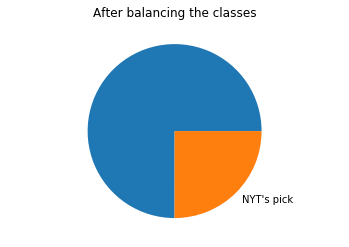

In [12]:
plt.axis('equal')
plt.pie(comments.editorsSelection.value_counts(), labels=("", "NYT's pick"));
plt.title("After balancing the classes");

**Once we balance the classes our goal is to predict the probability that a given comment is selected by NYT as editor's pick**

* So the target variable is given by the column editorsSelection. 
* We are training the classifier on commentBody and keeping articleID to partition the comments into train, test, validation sets below such that they do not share comments from the same article. 
* Thus, we need only three features articleID, commentBody and editorsSelection.

In [14]:
commentBody = comments.commentBody
nytpicks = comments.editorsSelection
articleID = comments.articleID

**We delete the comments dataframe to free up space since we have stored the three features which are required**

In [15]:
# Delete comments dataframe since it is no longer needed
del comments

# Collect residual garbage
gc.collect();

## 3.2 GroupKFold to split the data

**We use GroupKFold to split the data into train and test sets such that the two sets have comments from disjoint set of articles.**

**GroupKfold is a cross validation technique that splits the data by respecting additional information about groups. It is a variation of k-fold which ensures that the same group is not represented in both testing and training sets.**

**Here we used 5 splits for the GroupKFold**

In [16]:
for train_index, test_index in GroupKFold(n_splits=5).split(commentBody, nytpicks, groups=articleID):
    train_text, test_text = commentBody[train_index], commentBody[test_index] 
    train_target, test_target = nytpicks[train_index], nytpicks[test_index]
    train_groups, test_groups = articleID[train_index], articleID[test_index]
    
print("Number of comments for training:", train_text.shape[0])
print("Number of comments for testing:", test_text.shape[0])

Number of comments for training: 129107
Number of comments for testing: 32276


## 3.3 Obtaining the tf-idf vectors

**Next we get features using TFIDF vectorizer which stands for “Term Frequency – Inverse Document”  for words and characters and combine them using FeatureUnion**

**FeatureUnion it concatenates results of multiple objects. The estimator applies a list of transformer objects in parallel to the input data, then concatenates the results**

**By using tf-idf vectorization, the issue with respect to repitation of some common words like “the” or “and” will not appear many times since their large counts will not be very meaningful in the encoded vectors**

In [17]:
vectorizer = FeatureUnion([
    ('word_tfidf', TfidfVectorizer(
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=600,
    )),
    
    ('char_tfidf', TfidfVectorizer(
    analyzer='char',
    ngram_range=(2, 4),
    max_features=600,
    ))
])
start_vect = time()
vectorizer.fit(commentBody)
train_text = vectorizer.transform(train_text)
test_text = vectorizer.transform(test_text)

print("Vectorization Runtime: %0.2f Minutes"%((time() - start_vect)/60))

Vectorization Runtime: 7.74 Minutes


## 3.4 Logistic Regression coupled with Latent Semantic Analysis (LSA)

**Here we use Latent Semantic Analysis (LSA) to perform dimensionality reduction on the tf-idf vectors and then train the Logistic regression to make predictions. LSA is implemented as TruncatedSVD (singular value decomposition) in sklearn**

In [18]:
clf_logistic = Pipeline([
    ('lsa', TruncatedSVD(n_components=1000, random_state=0)), 
    ('logistic', LogisticRegression(C=150))  
])

**The tuned parameters obtained are used to train the model.**

In [19]:
def train(clf):
    clf.fit(train_text, train_target)
    
    test_prediction = clf.predict(test_text)
    print("Classification report:")
    print(classification_report(test_target, test_prediction))
    
    test_prediction_proba = clf.predict_proba(test_text)[:, 1]
    score = roc_auc_score(test_target, test_prediction_proba)
    print("ROC AUC Score: ", round(score, 4)) 
    
    score = log_loss(test_target, test_prediction_proba)
    print("logloss: ", round(score, 4))
    return test_prediction_proba

**After running the model we can see the AUC score and the logloss score.**

**Important thing here is to note the time it takes to run the model. It takes over 8 minutes to run the model**

In [20]:
start_vect = time()

test_prediction_proba_logistic = train(clf_logistic)

print()
print("Runtime for training logistic regression model and predicting probabilities for the test set is %0.2f Minutes"%((time() - start_vect)/60))

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     24207
           1       0.51      0.14      0.22      8069

    accuracy                           0.75     32276
   macro avg       0.64      0.55      0.54     32276
weighted avg       0.70      0.75      0.69     32276

ROC AUC Score:  0.723
logloss:  0.5038

Runtime for training logistic regression model and predicting probabilities for the test set is 16.63 Minutes


## 3.5 NB-Logistic Regression model

**Next we train NB Logistic model that combines Naive Bayes with Logistic Regression. We start by defining a class for the NB-logistic model.**

In [21]:
class NBL(LogisticRegression, BaseEstimator):
    def __init__(self, r=None, C=1, solver='sag', class_weight_balanced=False):
        self.r = r
        if class_weight_balanced:
            super().__init__(C=C, solver=solver, class_weight='balanced')
        else:
            super().__init__(C=C, solver=solver)
        
    def pr(self, X, y, y_i):
        p = X[np.where(y==y_i)[0]].sum(0)+1
        return (p+1)/((y==y_i).sum()+1)

    def fit(self, X, y):
        self.r = np.log(self.pr(X, y, 1) / self.pr(X, y, 0))
        X_nb = X.multiply(self.r)
        super().fit(X_nb, y)
        return self
    
    def predict(self, X):
        X_nb = X.multiply(self.r)
        return super().predict(X_nb)
    
    def predict_proba(self, X):
        X_nb = X.multiply(self.r)
        return super().predict_proba(X_nb)

**After running the model we can see the AUC score and the logloss score.**

**Here the time it takes to run the model is significantly less since it models the joint distribution of the features X and target variable Y which is the comments selected as NYT’s pick in our case, and then predicts the posterior probability given as P(y|x) (Generative model)**

In [22]:
clf_nb_logistic = NBL()

start_vect = time()

test_prediction_proba_nb_logistic = train_model(clf_nb_logistic)

print("Runtime for running GridSearchCV on NB-logistic regression model and predicting probabilities for the test set is %0.2f Minutes"%((time() - start_vect)/60))

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.86     24207
           1       0.53      0.09      0.16      8069

    accuracy                           0.75     32276
   macro avg       0.65      0.53      0.51     32276
weighted avg       0.71      0.75      0.68     32276

ROC AUC Score:  0.7231
logloss:  0.5037
Runtime for running GridSearchCV on NB-logistic regression model and predicting probabilities for the test set is 0.26 Minutes


## 3.6 Plotting the ROC and Precision-Recall curve

**Lastly, we compare the two classifiers by plotting the respective ROC and Precision-Recall curves**

**ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.**

**Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.**

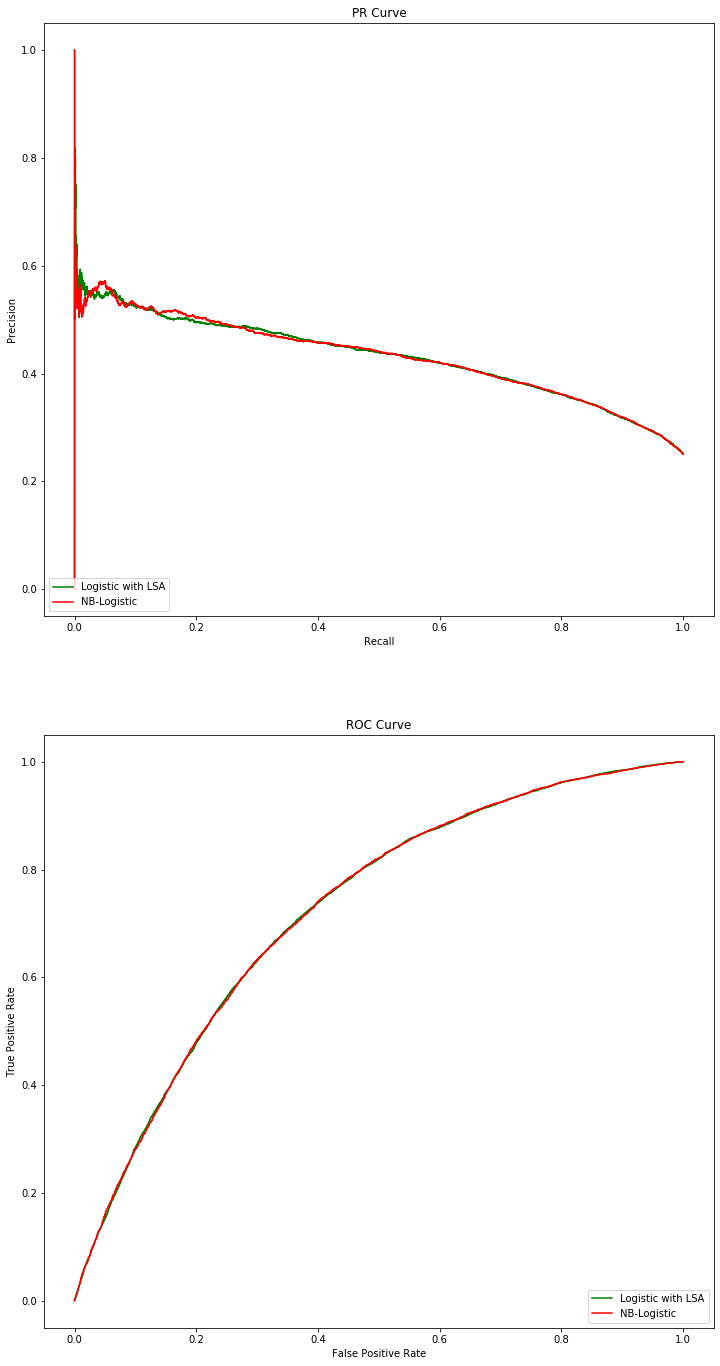

In [23]:
def ROC_PR_curves(test_prediction_proba):
    p, r, _ = precision_recall_curve(test_target, test_prediction_proba)
    tpr, fpr, _ = roc_curve(test_target, test_prediction_proba)
    return p, r, tpr, fpr

fig = plt.figure(figsize=(12,24))

ax1 = fig.add_subplot(2,1,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(2,1,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')


p, r, tpr, fpr = ROC_PR_curves(test_prediction_proba_logistic) 
ax1.plot(r, p, c='g', label="Logistic with LSA")
ax2.plot(tpr, fpr, c='g', label="Logistic with LSA")

p, r, tpr, fpr = ROC_PR_curves(test_prediction_proba_nb_logistic) 
ax1.plot(r, p, c='r', label="NB-Logistic")
ax2.plot(tpr, fpr, c='r', label="NB-Logistic") 

ax1.legend(loc='lower left')    
ax2.legend(loc='lower right')

plt.show()

## Conclusion

**The two classifiers are very similar in performance and they both form a strong baseline for predicting the selection of comments on NYT articles as editor's picks with reasonably good ROC score of 0.72**

**But the difference here is the time it takes to run the model. NB Logistic takes much lesser time compared to Logistic Regression coupled with LSA.**